✅ Dataset found at: /kaggle/input/phl-exoplanet-catalog/phl_exoplanet_catalog_2019.csv

--- Missing Value Summary ---
                    Missing Count   Missing %
S_DISC                       4048  100.000000
S_MAGNETIC_FIELD             4048  100.000000
P_DENSITY                    3342   82.559289
P_GRAVITY                    3342   82.559289
P_ESCAPE                     3342   82.559289
P_OMEGA                      3302   81.571146
P_INCLINATION                3204   79.150198
S_TYPE                       2678   66.156126
P_ECCENTRICITY               2668   65.909091
P_IMPACT_PARAMETER           2639   65.192688
P_HILL_SPHERE                2502   61.808300
P_MASS                       2450   60.523715
S_AGE                        2017   49.827075
P_SEMI_MAJOR_AXIS            1681   41.526680
S_METALLICITY                1206   29.792490
P_RADIUS                      909   22.455534
S_TIDAL_LOCK                  767   18.947628
S_MASS                        765   18.898221
S_LOG_G 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


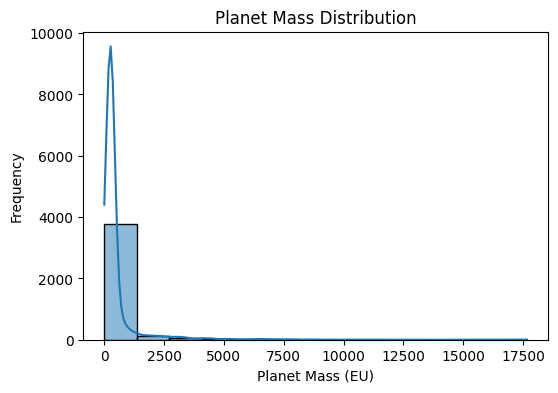


✅ DATA IMPUTATION COMPLETED SUCCESSFULLY!
📁 File saved as: cleaned_exoplanet_data.csv


In [5]:
# ============================================================
# HABITABLE PLANET HUNTER – DATA IMPUTATION PIPELINE
# Compatible with Python 3.10 | Kaggle | Colab
# ============================================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder

# ============================================================
# 1. AUTO-DETECT DATASET
# ============================================================
DATA_DIR = "/kaggle/input"

csv_file = None
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)
            break
    if csv_file:
        break

if csv_file is None:
    raise FileNotFoundError("❌ Dataset not found.")

print(f"✅ Dataset found at: {csv_file}")

df = pd.read_csv(csv_file)

# ============================================================
# 2. SELECT APPROVED 30 COLUMNS
# ============================================================
approved_columns = [
    "P_MASS","P_RADIUS","P_DENSITY","P_GRAVITY","P_ESCAPE","P_TYPE",
    "P_PERIOD","P_SEMI_MAJOR_AXIS","P_ECCENTRICITY","P_INCLINATION",
    "P_OMEGA","P_PERIASTRON","P_APASTRON","P_IMPACT_PARAMETER","P_HILL_SPHERE",
    "S_MASS","S_RADIUS","S_LUMINOSITY","S_TEMPERATURE","S_AGE",
    "S_METALLICITY","S_LOG_G","S_TYPE","S_MAG","S_DISC","S_MAGNETIC_FIELD",
    "S_SNOW_LINE","S_TIDAL_LOCK","P_DETECTION","P_DISTANCE",
    "P_HABITABLE"
]

df = df[approved_columns]

# ============================================================
# 3. MISSING VALUE ANALYSIS
# ============================================================
missing_summary = pd.DataFrame({
    "Missing Count": df.isnull().sum(),
    "Missing %": (df.isnull().sum() / len(df)) * 100
}).sort_values(by="Missing %", ascending=False)

print("\n--- Missing Value Summary ---")
print(missing_summary)

# ============================================================
# 4. DROP 100% EMPTY COLUMNS
# ============================================================
fully_missing_cols = missing_summary[missing_summary["Missing %"] == 100].index.tolist()
print("\n❌ Dropping fully empty columns:", fully_missing_cols)

df.drop(columns=fully_missing_cols, inplace=True)

# ============================================================
# 5. SPLIT NUMERICAL & CATEGORICAL
# ============================================================
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

# ============================================================
# 6. NUMERICAL IMPUTATION (MEDIAN)
# ============================================================
median_imputer = SimpleImputer(strategy="median")
df[numerical_cols] = median_imputer.fit_transform(df[numerical_cols])

# ============================================================
# 7. KNN IMPUTATION (PHYSICS-AWARE)
# ============================================================
knn_features = [
    col for col in ["P_MASS", "P_RADIUS", "P_DENSITY", "S_MASS", "S_RADIUS"]
    if col in df.columns
]

knn_imputer = KNNImputer(n_neighbors=5)
df[knn_features] = knn_imputer.fit_transform(df[knn_features])

# ============================================================
# 8. CATEGORICAL IMPUTATION
# ============================================================
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# ============================================================
# 9. ENCODE CATEGORICAL FEATURES
# ============================================================
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# ============================================================
# 10. FEATURE ENGINEERING
# ============================================================
df["ORBITAL_STABILITY"] = df["P_SEMI_MAJOR_AXIS"] / (df["P_ECCENTRICITY"] + 1)
df["STELLAR_INFLUENCE"] = df["S_LUMINOSITY"] / (df["P_SEMI_MAJOR_AXIS"] ** 2)
df["GRAVITY_DENSITY_INDEX"] = df["P_GRAVITY"] * df["P_DENSITY"]

# ============================================================
# 11. HANDLE INFINITE VALUES (IMPORTANT)
# ============================================================
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# ============================================================
# 12. FINAL VALIDATION
# ============================================================
print("\n✅ Missing values after processing:")
print(df.isnull().sum())

# ============================================================
# 13. VISUALIZATION
# ============================================================
plt.figure(figsize=(6,4))
sns.histplot(df["P_MASS"], kde=True)
plt.title("Planet Mass Distribution")
plt.xlabel("Planet Mass (EU)")
plt.ylabel("Frequency")
plt.show()

# ============================================================
# 14. SAVE CLEAN DATASET
# ============================================================
df.to_csv("cleaned_exoplanet_data.csv", index=False)

print("\n✅ DATA IMPUTATION COMPLETED SUCCESSFULLY!")
print("📁 File saved as: cleaned_exoplanet_data.csv")